In [1]:
%load_ext autoreload
%autoreload 2

import os
from jax import config
config.update("jax_enable_x64", True)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

import tensorflow_datasets as tfds  # TFDS for MNIST
import tensorflow as tf             # TensorFlow operations

# from image_distribution_models import PixelCNN

from cleanplots import *
import jax.numpy as np
from jax.scipy.special import logsumexp

from encoding_information.models.pixel_cnn import PixelCNN



2023-10-21 15:05:10.810596: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-21 15:05:11.443776: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cublas/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_cupti/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_nvcc/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_nvrtc/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_runtime/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/pyth

In [8]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()


# import numpy as onp
# train_images = onp.random.randint(0, 255, train_images.shape).astype('uint8')

# # make some bimodal IID data
# train_images = onp.where(onp.random.rand(*train_images.shape) > 0.5, 250, 5) + onp.random.normal(0, 10, train_images.shape)



In [3]:
# Generate gaussian mixture IID pixel values

import jax
from tqdm import tqdm
import numpy as onp
n_images = 8000
image_size = 28
# image_size = 5

# Number of Gaussian components
n_components = 7

# Randomly generate means, std_devs, and weights
onp.random.seed(5)  # For reproducibility
means = onp.random.uniform(0, 255, n_components)
std_devs = onp.random.uniform(1, 50, n_components)
weights = onp.random.dirichlet(onp.ones(n_components), size=1).flatten()

# Initialize array to store images
images = []

# Vectorized image generation
for i in tqdm(range(n_images)):
    # Generate component indices based on weights
    component_indices = onp.random.choice(n_components, size=(image_size, image_size), p=weights)
    
    # Draw from Gaussians
    key = jax.random.PRNGKey(i)
    # pixel_values = onp.random.normal(means[component_indices], std_devs[component_indices])
    pixel_values = means[component_indices] + std_devs[component_indices] * jax.random.normal(key, shape=(image_size, image_size))
    
    # Clip to [0, 255]
    pixel_values = np.clip(pixel_values, 0, 255)
    
    images.append(pixel_values)

train_images = np.array(images)
train_images = np.where(train_images > 0, train_images, 0)


100%|██████████| 8000/8000 [00:10<00:00, 750.04it/s]


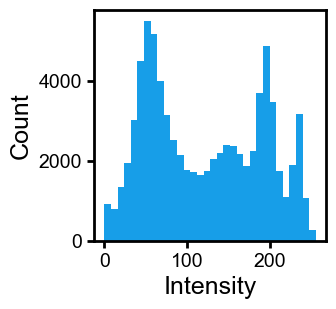

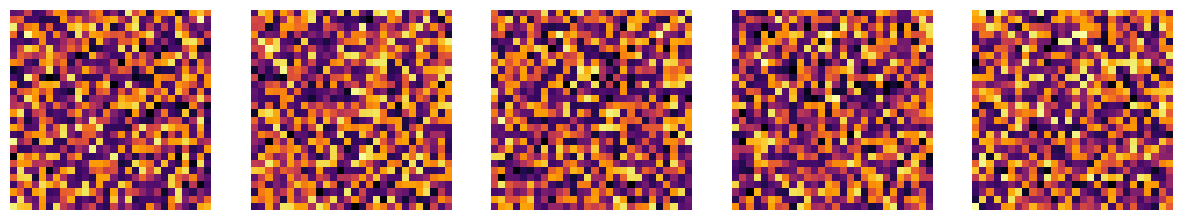

In [4]:
# histogram of pixel values
fig, ax = plt.subplots(1,1, figsize=(3,3))
ax.hist(train_images[:100].flatten(), bins=32)
ax.set(xlabel='Intensity', ylabel='Count')

# plot a few images
fig, ax = plt.subplots(1,5, figsize=(15,3))
for i in range(5):
    ax[i].imshow(train_images[i], cmap='inferno')
    ax[i].axis('off')
    

## train and plot conditionals

In [17]:
seed = 0

num_hidden_channels = 64
num_mixture_components = 40

pixel_cnn = PixelCNN(num_hidden_channels=num_hidden_channels, num_mixture_components=num_mixture_components)
pixel_cnn.fit(train_images, max_epochs=5)          

Computing loss: 15it [00:02,  7.03it/s]


Initial validation NLL: 881.29


Epoch 1: 100%|██████████| 100/100 [00:08<00:00, 11.40it/s]
Computing loss: 15it [00:00, 75.77it/s]


Epoch 1: validation NLL: 2.55


Epoch 2: 100%|██████████| 100/100 [00:02<00:00, 33.84it/s]
Computing loss: 15it [00:00, 91.73it/s]


Epoch 2: validation NLL: 2.55


Epoch 3: 100%|██████████| 100/100 [00:03<00:00, 32.71it/s]
Computing loss: 15it [00:00, 82.14it/s]


Epoch 3: validation NLL: 2.53


Epoch 4: 100%|██████████| 100/100 [00:03<00:00, 32.23it/s]
Computing loss: 15it [00:00, 89.72it/s]


Epoch 4: validation NLL: 2.54


Epoch 5: 100%|██████████| 100/100 [00:02<00:00, 33.96it/s]
Computing loss: 15it [00:00, 88.44it/s]

Epoch 5: validation NLL: 2.53


[881.293701171875,
 2.5469305515289307,
 2.5493719577789307,
 2.5252015590667725,
 2.538151741027832,
 2.5259528160095215]

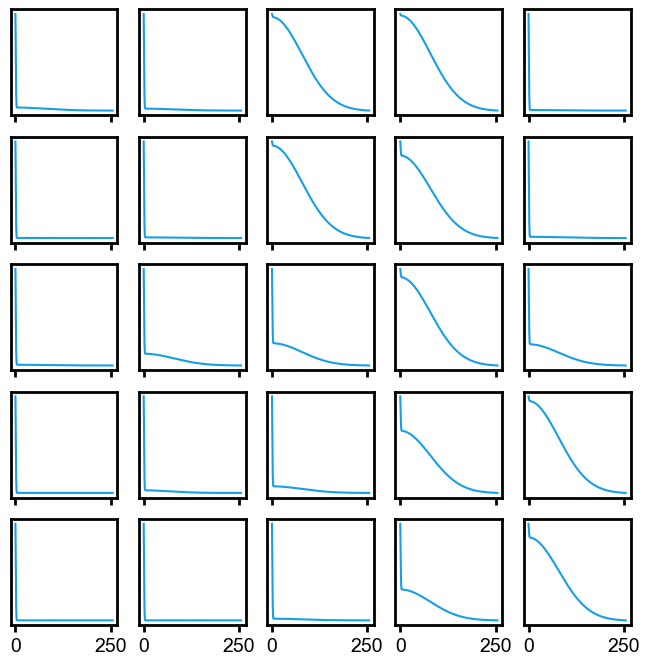

: 

In [18]:
start = 10
end = 15
num = end - start

mu, sigma, mix_logit = pixel_cnn._flax_model.apply(pixel_cnn._state.params, train_images[:1])

y = np.arange(0, 256).reshape(-1, 1, 1, 1, 1)
nll = pixel_cnn._flax_model.compute_nll(mu, sigma, mix_logit, y)
prob = np.exp(-nll)

fig, ax = plt.subplots(num, num, figsize=(8, 8), sharex=True)
for i, k in enumerate(range(start, end)):
    for j, h in enumerate(range(start, end)):
        ax[i,j].plot(prob[..., k, h])
        ax[i, j].set(yticks=[])

[Text(0.5, 0, 'Mu'), Text(0, 0.5, 'Count')]

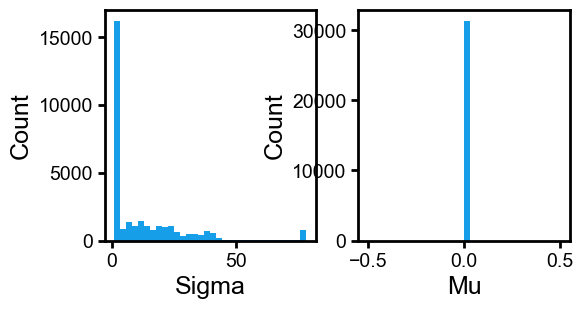

In [16]:
# plot histograms of sigmas and mus
fig, ax = plt.subplots(1,2, figsize=(6,3))
ax[0].hist(sigma.flatten(), bins=32)
ax[0].set(xlabel='Sigma', ylabel='Count')
ax[1].hist(mu.flatten(), bins=32)
ax[1].set(xlabel='Mu', ylabel='Count')